In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12


# import seaborn as sns

# from imblearn.over_sampling import SMOTE

In [82]:
df = pd.read_csv("/Users/ianchang/0.Workspaces/slaCoefficientProject/Origination Data/DTT SLA Summary - Overall Summary.csv").drop(columns=["Unnamed: 0", "partner_id", "partner", "xfr_request_id", "request_id", "true_SLA", "runtime_per_day", "payment_code"])

ERROR! Session/line number was not unique in database. History logging moved to new session 12


In [83]:
df['source_language'] = df['source_language'].replace('--', 'en')
df

,author,title_id,package_id,title_desc,asset_type,content_category,reason_code,original_audio_language,source_language,target_language,runtime_minutes,current_state,submit_date,due_date,start_date,on_time,billing_events
0,kristopherbrame@glozinc.com,81517717,2096846,"Outer Banks: Season 3: ""Secret of the Gnomon""",LANGUAGE_TEMPLATE,VIDEO,RUSH,en,en,en,77.6,AUTHORING_COMPLETE,2023-01-03,2023-01-05,2022-12-30,1,NaN
1,eunaejo@glozinc.com,81517716,2096828,"Outer Banks: Season 3: ""Welcome to Wild Ridge""",SUBTITLE,VIDEO,RUSH,en,en,ko,50.6,AUTHORING_COMPLETE,2023-01-03,2023-01-04,2023-01-01,1,705.0
2,beatakrenzelokova@glozinc.com,81462347,2081320,"The Recruit: Season 1: ""I.M.F.T.B.S.""",CLOSED_CAPTIONING,VIDEO,RUSH,en,en,cs,56.2,AUTHORING_COMPLETE,2023-01-03,2023-01-07,2022-12-29,1,NaN
3,coenrees@glozinc.com,81554232,2097639,"The Night Agent: Season 1: ""Eyes Only""",LANGUAGE_TEMPLATE,VIDEO,RUSH,en,en,en,46.9,AUTHORING_COMPLETE,2023-01-03,2023-01-03,2022-12-31,1,NaN
4,marekbuchtel@glozinc.com,81462343,2081336,"The Recruit: Season 1: ""I.Y.D.I.A.A.C.""",CLOSED_CAPTIONING,VIDEO,RUSH,en,en,cs,55.0,AUTHORING_COMPLETE,2023-01-04,2023-01-07,2022-12-31,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12758,geiramundsen@glozinc.com,81486044,2119758,"Bill Russell: Legend: ""Part 1""",SUBTITLE,VIDEO,STANDARD,en,en,nb,92.1,AUTHORING_COMPLETE,2023-01-01,2023-01-02,2022-12-22,1,1506.0
12759,jiayauwei@glozinc.com,81427495,2097180,"La legge di Lidia Poët: Season 1: ""Episode 3""",SUBTITLE,VIDEO,STANDARD,it,en,zh-Hant,42.8,AUTHORING_COMPLETE,2023-01-01,2023-01-03,2022-12-27,1,467.0
12760,brandonelalouf@glozinc.com,81616038,2132627,"How to Get Rich: Season 1: ""Episode 7""",CLOSED_CAPTIONING,VIDEO,STANDARD,en,en,en,29.7,AUTHORING_COMPLETE,2023-01-01,2023-01-02,2022-12-30,1,NaN
12761,ellenliang@glozinc.com,81597261,2096062,"Never Have I Ever: Season 4: ""Episode 3""",SUBTITLE,VIDEO,STANDARD,en,en,zh-Hans,24.1,AUTHORING_COMPLETE,2023-01-01,2023-01-17,2022-12-30,1,478.0


In [84]:
df['submit_date'] = pd.to_datetime(df['submit_date'])
df["submit_date"] = df["submit_date"].dt.floor('D')

# Extract year and month, then create the submit_month column
df['submit_month'] = df['submit_date'].dt.to_period('M')

In [85]:
origination_by_month = df[["on_time", "submit_month"]].groupby(by="submit_month").mean().reset_index()


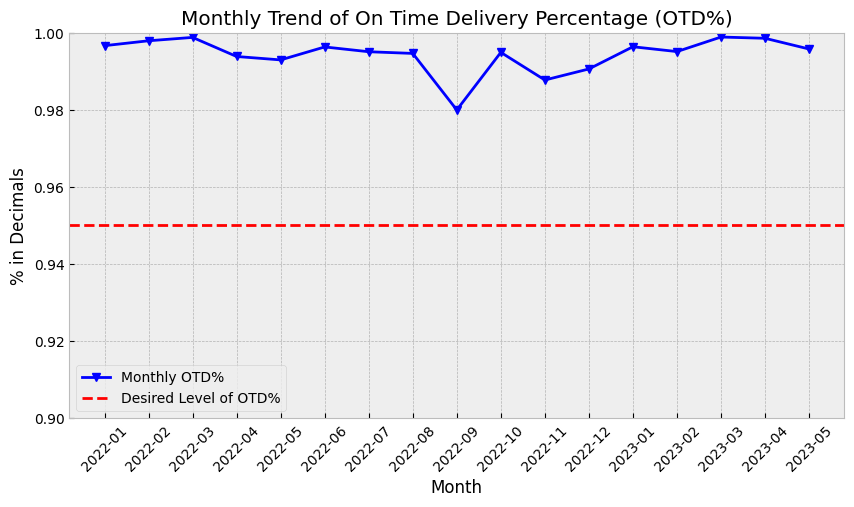

In [86]:
fig, ax = plt.subplots(figsize = (10,5))
plt.style.use('bmh')

ax.plot(origination_by_month["submit_month"].astype("str"), origination_by_month["on_time"], marker="v", label="Monthly OTD%", color="blue")


ax.set_ylim(0.9, 1)
ax.axhline(y=0.95, color='red', linestyle='--', label="Desired Level of OTD%")
ax.set_title("Monthly Trend of On Time Delivery Percentage (OTD%)")
ax.set_xlabel("Month")
ax.set_ylabel("% in Decimals")

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [87]:
import random
import string

def get_random_string(length=8):
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(length))


df['author'] = df['author'].str.replace(r'@.*', '', regex=True)

unique_authors = df['author'].unique()

author_mapping = {}

for author in unique_authors:
    author_mapping[author] = get_random_string()

df['author_anonymous'] = df['author'].map(author_mapping)


def get_random_numbers():
    return random.randint(2000000,2999999)

unique_packageID = df["package_id"].unique()

packageID_mapping = {}

for id in unique_packageID:
    packageID_mapping[id] = get_random_numbers()

df['package_id_new'] = df['package_id'].map(packageID_mapping)

In [88]:
df_orig = df[['author_anonymous', 'package_id_new', 'asset_type',
       'content_category', 'reason_code', 'original_audio_language',
       'source_language', 'target_language', 'runtime_minutes',
        'start_date', 'submit_date', 'due_date', 'on_time']]

df_orig.to_csv('df_orig.csv', index = False)

## Service Level Agreement Based on Asset Types:

● Standard SLA for all subtitles and language templates: 15 RTM per Day

● Rush SLA for all subtitles and language templates: 30 RTM Day

● Standard SLA for CC for Original Audio language: 30 RTM per Day

● Rush SLA for CC for Original Audio language: 60 RTM per Day

● Standard SLA for CC for Non Original Audio language: 15 RTM per Day

● Rush SLA for CC for Non Original Audio language: 30 RTM per Day

In [89]:
# Initialize  
df["expected_daily_output"] = 0

for index, row in df.iterrows():
    if row["asset_type"] == "SUBTITLE":
        if row["reason_code"] == "STANDARD":
            df.at[index, "expected_daily_output"] = 15
        elif row["reason_code"] == "RUSH":
            df.at[index, "expected_daily_output"] = 30

    elif row["asset_type"] == "CLOSED_CAPTIONING":
        if row["original_audio_language"] == row["target_language"]:
            if row["reason_code"] == "STANDARD":
                df.at[index, "expected_daily_output"] = 30
            elif row["reason_code"] == "RUSH":
                df.at[index, "expected_daily_output"] = 60
        else:
            if row["reason_code"] == "STANDARD":
                df.at[index, "expected_daily_output"] = 15
            elif row["reason_code"] == "RUSH":
                df.at[index, "expected_daily_output"] = 30
    
    elif row["asset_type"] == "LANGUAGE_TEMPLATE":
        if row["reason_code"] == "STANDARD":
            df.at[index, "expected_daily_output"] = 15
        elif row["reason_code"] == "RUSH":
            df.at[index, "expected_daily_output"] = 30

df = df[['author_anonymous', 'package_id_new', 'asset_type',
       'content_category', 'reason_code', 'original_audio_language',
       'source_language', 'target_language',"expected_daily_output", 'runtime_minutes',
        'start_date', 'submit_date', 'due_date', 'on_time',]]

In [90]:
import pandas as pd

def calculate_business_days(start_date_str, end_date_str):
    """
    Calculate the number of business days between two dates excluding weekends.

    Parameters:
    start_date_str (str): The start date in YYYY-MM-DD format.
    end_date_str (str): The end date in YYYY-MM-DD format.

    Returns:
    int: The number of business days between the two dates.
    """
    
    # Convert the date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    
    # Calculate the number of business days (excluding weekends)
    business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # Return the count of business days
    return len(business_days)


In [91]:
import math

for index, row in df.iterrows():
    df.at[index,"num_days_spent"] = calculate_business_days(row["start_date"], row["submit_date"])

for index, row in df.iterrows():
    df.at[index, "expected_TAT"] = np.ceil(row["runtime_minutes"] / row["expected_daily_output"])

for index, row in df.iterrows():    
    if row["num_days_spent"] <= row["expected_TAT"]:
        df.at[index, "on_time_actual"] = 1
    else:
        df.at[index, "on_time_actual"] = 0

df = df.rename(columns={"on_time": "on_time_current"})

df = df[['author_anonymous', 'package_id_new', 'asset_type',
       'content_category', 'reason_code', 'original_audio_language',
       'source_language', 'target_language', 'runtime_minutes',
        'start_date', 'submit_date', 'due_date', 'on_time_current', "expected_daily_output", 'num_days_spent','expected_TAT','on_time_actual']]

/var/folders/wy/1wxdktc96n90599bcthy_00h0000gn/T/ipykernel_43120/3601330993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index,"num_days_spent"] = calculate_business_days(row["start_date"], row["submit_date"])
/var/folders/wy/1wxdktc96n90599bcthy_00h0000gn/T/ipykernel_43120/3601330993.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, "expected_TAT"] = np.ceil(row["runtime_minutes"] / row["expected_daily_output"])
/var/folders/wy/1wxdktc96n90599bcthy_00h0000gn/T/ipykernel_43120/36

In [92]:
df_ontime_comparison = df.groupby(by=["asset_type"]).agg({"on_time_current": "mean", "on_time_actual": "mean"}).reset_index()
df_ontime_comparison

,asset_type,on_time_current,on_time_actual
0,CLOSED_CAPTIONING,0.990826,0.406728
1,LANGUAGE_TEMPLATE,0.992024,0.363908
2,SUBTITLE,0.995982,0.485170


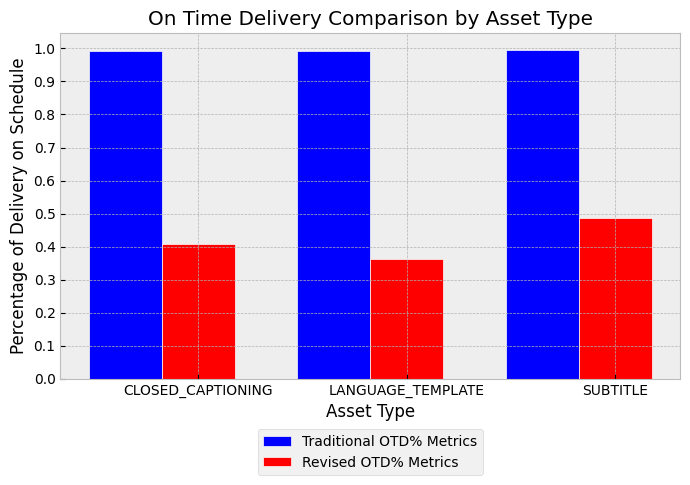

In [93]:
bar_width = .35

r1 = np.arange(len(df_ontime_comparison["asset_type"]))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(7,5))

ax.bar(r1, df_ontime_comparison["on_time_current"], width = bar_width, edgecolor="white", label="Traditional OTD% Metrics", color = "blue")
ax.bar(r2, df_ontime_comparison["on_time_actual"], width = bar_width, edgecolor="white", label="Revised OTD% Metrics", color = "red")

ax.set_xticks([r + bar_width for r in range(len(df_ontime_comparison["asset_type"]))])
ax.set_xticklabels(df_ontime_comparison["asset_type"])
ax.set_xlabel('Asset Type')
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax.set_ylabel('Percentage of Delivery on Schedule')
ax.set_title('On Time Delivery Comparison by Asset Type')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=1)

plt.tight_layout()

plt.show()

## TAT Multiplier Calculation by Asset Type


In [105]:
for index, row in df.iterrows():
    df.at[index, "tat_coef"] = row["num_days_spent"] / row["expected_TAT"]

tat_coefs = df.groupby(by=["asset_type", "reason_code", "source_language","target_language"]).agg({"tat_coef": ['count', 'mean', 'std', 'min', 'median', 'max']}).reset_index()

tat_coefs.columns = ['_'.join(col).strip() if col[1] != "" else col[0] for col in tat_coefs.columns.values]

In [108]:
tat_coefs.to_csv('TAT_Multipliers_20222023.csv', index=False)

## Creating Buckets for TAT Multiplier-Based Scoring

- Good: TAT Multiplier of less than or equal to 1 | Score of 3
- Acceptable: TAT Multiplier of less than or equal to Mean TAT Multiplier by Asset Type (CC, Template, Subtitle) | Score of 2
- Poor: TAT Multiplier of less than or equal to Mean TAT Multiplier + 1 Standard Deviation by Asset Type (CC, Template, Subtitle) | Score of 1
- Very Poor: TAT Multiplier of more than Mean TAT Multiplier + 1 Standard Deviation by Asset Type (CC, Template, Subtitle) | Score of 0

In [107]:
df["tat_coef_comp"] = None

for index, row in df.iterrows():
    asset_type = row["asset_type"]
    source = row["source_language"]
    target = row["target_language"]
    reasoncode = row["reason_code"]
    
    comp_mean = tat_coefs.loc[
        (tat_coefs['asset_type'] == asset_type) & (tat_coefs['reason_code'] == reasoncode) & (tat_coefs['source_language'] == source) & (tat_coefs['target_language'] == target), 'tat_coef_mean']
    
    comp_std = tat_coefs.loc[
        (tat_coefs['asset_type'] == asset_type) &
        (tat_coefs['reason_code'] == reasoncode) &
        (tat_coefs['source_language'] == source) &
        (tat_coefs['target_language'] == target), 
        'tat_coef_std']

    if not comp_mean.empty:
        df.at[index, "tat_coef_comp"] = comp_mean.values[0]
        df.at[index, "tat_coef_std"] = comp_std.values[0]
    else:
        df.at[index, "tat_coef_comp"] = None
        df.at[index, "tat_coef_std"] = None

In [109]:
df["deliver_score"] = 0

for index, row in df.iterrows():
    if row["tat_coef"] <= 1:
        df.at[index, "deliver_score"] = 3
    elif row["tat_coef"] <= row["tat_coef_comp"]:
        df.at[index, "deliver_score"] = 2
    elif row["tat_coef"] <= row["tat_coef_comp"] + row["tat_coef_std"]:
        df.at[index, "deliver_score"] = 1
    elif row["tat_coef"] > row["tat_coef_comp"] + row["tat_coef_std"]:
        df.at[index, "deliver_score"] = 0

In [110]:
df[df["deliver_score"] <= 1]

,author_anonymous,package_id_new,asset_type,content_category,reason_code,original_audio_language,source_language,target_language,runtime_minutes,start_date,...,due_date,on_time_current,expected_daily_output,num_days_spent,expected_TAT,on_time_actual,tat_coef,tat_coef_comp,tat_coef_std,deliver_score
9,jErsnGvu,2040909,CLOSED_CAPTIONING,VIDEO,RUSH,en,en,cs,52.3,2022-12-23,...,2023-01-07,1,30,11.0,2.0,0.0,5.500000,3.25,2.150581,0
10,SfdYcbsL,2927795,SUBTITLE,VIDEO,RUSH,en,en,ko,46.9,2022-12-28,...,2023-01-06,1,30,8.0,2.0,0.0,4.000000,1.771008,1.646353,0
13,SfdYcbsL,2691042,SUBTITLE,VIDEO,RUSH,en,en,ko,44.3,2023-01-01,...,2023-01-09,1,30,5.0,2.0,0.0,2.500000,1.771008,1.646353,1
18,rnkzBteG,2916470,CLOSED_CAPTIONING,VIDEO,RUSH,en,en,en,77.6,2023-01-10,...,2023-01-13,1,60,4.0,2.0,0.0,2.000000,1.920751,1.709007,1
19,eFKprdtC,2671025,LANGUAGE_TEMPLATE,VIDEO,RUSH,en,en,en,44.6,2023-01-07,...,2023-01-15,1,30,5.0,2.0,0.0,2.500000,2.078,1.348193,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12749,LQVSJeWk,2069231,SUBTITLE,VIDEO,STANDARD,en,en,ms,42.3,2022-12-16,...,2023-01-14,1,15,11.0,3.0,0.0,3.666667,1.74381,1.398262,0
12750,SpDswDiq,2417160,SUBTITLE,VIDEO,STANDARD,en,en,fil,49.7,2022-12-20,...,2023-01-01,1,15,9.0,4.0,0.0,2.250000,1.882464,2.806614,1
12751,qqspWYeG,2805396,SUBTITLE,VIDEO,STANDARD,en,en,zh-Hans,54.1,2022-12-26,...,2023-01-09,1,15,5.0,4.0,0.0,1.250000,1.213682,0.988031,1
12754,SpDswDiq,2926438,SUBTITLE,VIDEO,STANDARD,en,en,fil,59.1,2022-12-12,...,2023-01-01,1,15,15.0,4.0,0.0,3.750000,1.882464,2.806614,1


## Calculating Average Score of Each Vendor for Monitoring

In [111]:
vendor_scores = df[["author_anonymous", "runtime_minutes", "num_days_spent","tat_coef","deliver_score"]].groupby(by="author_anonymous").agg({"runtime_minutes": "sum","num_days_spent": "mean", "tat_coef": "mean", "deliver_score": "mean"}).sort_values(by="deliver_score").reset_index()

In [112]:
vendor_scores

,author_anonymous,runtime_minutes,num_days_spent,tat_coef,deliver_score
0,BRPrdFqH,88.3,13.000000,2.166667,0.000000
1,mRzoESsY,63.8,12.000000,2.400000,0.000000
2,VPehSWVc,271.1,7.916667,3.958333,0.333333
3,VafxRaSZ,975.9,18.931034,6.747126,0.655172
4,qYbdeeIr,234.1,6.600000,3.300000,0.800000
...,...,...,...,...,...
301,RTthqfjS,98.4,3.000000,0.750000,3.000000
302,godFofNU,87.0,5.000000,0.833333,3.000000
303,KazfMZrf,50.0,1.000000,0.250000,3.000000
304,QccgJRBH,228.0,6.500000,0.833333,3.000000


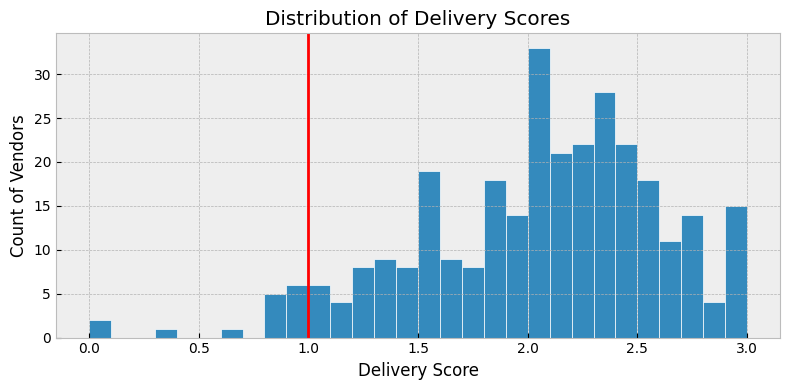

In [121]:
fig, ax = plt.subplots(figsize=(8,4))

ax.hist(vendor_scores["deliver_score"], bins=30, linewidth=0.5, edgecolor="white")

ax.set_xlabel('Delivery Score')
ax.set_ylabel('Count of Vendors')
ax.set_title('Distribution of Delivery Scores')
ax.axvline(1.0, color= "red")

plt.tight_layout()

plt.show()
plt.show()

In [114]:
print(vendor_scores[vendor_scores["deliver_score"] <= 1])
print()
print("These vendors would be subject to retraining of submission best practices or even offboarding")

   author_anonymous  runtime_minutes  num_days_spent  tat_coef  deliver_score
0          BRPrdFqH             88.3       13.000000  2.166667       0.000000
1          mRzoESsY             63.8       12.000000  2.400000       0.000000
2          VPehSWVc            271.1        7.916667  3.958333       0.333333
3          VafxRaSZ            975.9       18.931034  6.747126       0.655172
4          qYbdeeIr            234.1        6.600000  3.300000       0.800000
5          zNDBxYEJ           1850.7       13.660377  5.360063       0.811321
6          WNAijRvn           1592.3       11.250000  5.477381       0.865385
7          sViwLcJM            323.5        6.250000  2.187500       0.875000
8          WwuFZnxe            667.6        7.470588  2.392157       0.882353
9          qAMQcXqJ            304.8        8.727273  4.118182       0.909091
10         WRAWzIrn            672.0       16.818182  5.017906       0.909091
11         ZNZzKLfl            621.8        9.214286  3.646684  

In [115]:
df.to_csv('df_newTAT.csv', index=False)
vendor_scores.to_csv('vendor_scores.csv', index = False)